In [1]:
# Add module path for demo.
# Todo: make wheel file -> setup file -> pip install tsx-**.whl
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import ASyncTimeSlicer
from tsx.xai.lime import LIMETimeSeries

from data_util import *
from viz import *


In [3]:
# Prepare Data Set
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)

In [4]:
# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))
_df = df_norm.loc[:, df_norm.columns != 'wind_direction']
# plt_x_instance(_df)

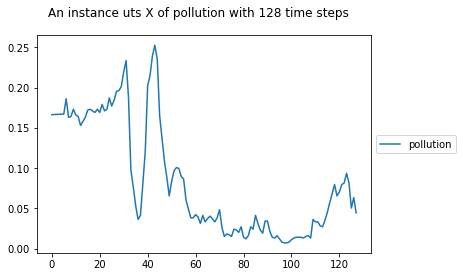

In [5]:
# uts - x
x = get_instance_x(df_norm, n_steps, ['pollution'])
x_uts = x.loc[:, x.columns != 'wind_direction']
title = f"An instance uts X of pollution with {n_steps} time steps"

plt_x_instance(x_uts, title)

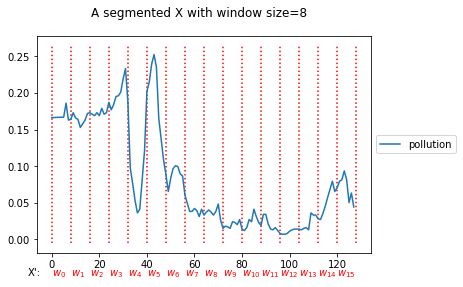

In [6]:
# uts - x-segmented
title = f"A segmented X with window size={window_size}"
plt_x_segmented(x_uts, window_size, title, label_pos=-0.05)

### Predict Function or explaining models

In [7]:
# Perturbation Async
samples_size = 10
ts_x = x.values.T # (n_features, n_steps) 
pert = ASyncTimeSlicer(window_size=window_size, replacement_method="zeros")
uts_sample_zeros = pert.perturb(ts_x, n_samples=samples_size)
uts_sample_zeros = list(uts_sample_zeros)

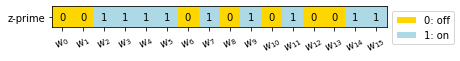

In [15]:
# Visualization Perturbation - Async and z_prime
z_prime, z, _, = uts_sample_zeros[0]
z_prime = z_prime.reshape(1, -1)
plt_sample_z_prime(z_prime, ylabels=['z-prime'])
plt_hide_subplot_xlabel(plt.gcf())

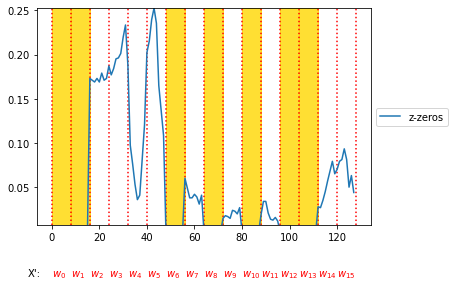

In [14]:
plt_sample_z(x, z, z_prime, ["z-zeros"], window_size, label_pos=-0.05)

In [10]:
# Plot XAI Weight
plt_coef(ts_lime.coef, feature_names=["coef-sync"], legend=False, title=False)

NameError: name 'ts_lime' is not defined

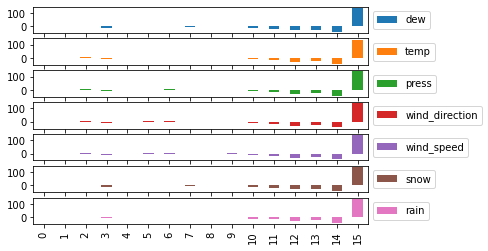

In [12]:
# Alternative
coef = ts_lime.coef
coef = np.broadcast_to(coef, (n_variables, len(coef)))

plt_coef(coef, feature_names=independents, legend=False, title=False)


### Multiple run and average

In [14]:
instances = []
n_instances = 10
for i in range(n_instances):
    _x_df = get_instance_x(df_norm, n_steps, independents)
    instances.append(_x_df.values.T)

In [18]:
ts_lime_n_runs = LIMETimeSeries(scale='sync', window_size=window_size, sample_size=100)
ts_lime_n_runs.explain_instances(instances, predict_fn=predict_fn)

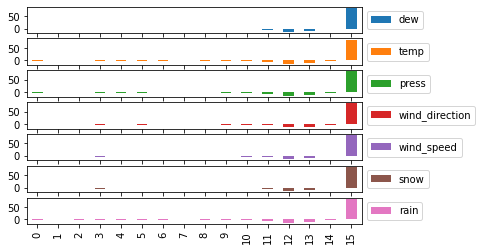

In [21]:
coef = ts_lime_n_runs.coef
coef = np.broadcast_to(coef, (n_variables, len(coef)))
plt_coef(coef, feature_names=independents, legend=False, title=False)